In [1]:
%pylab inline
from astropy.time import Time
import matplotlib.pylab as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Algorithm

Beamshape of the MeerKAT telescope showing the relation between beamformer and correlator. Different representations of the same data

Beamformer:   
$<BF_{pow}> = <(A_1+A_2+A_3+A_4)\times(A_1+A_2+A_3+A_4)^H>$ 

Correlator:   
$<auto_{pow}> = A_1A_1^H+A_2A_2^H+A_3A_3^H+A_4A_4^H$   
$<cross_{pow}> = A_1A_2^H+A_1A_3^H+A_1A_4^H+A_2A_3^H+A_2A_4^H+A_3A_4^H$   
$<cross_{pow}>_{conj} = <cross_{pow}>^H$ 

Tied-array beam contruction per polarisation:    
$TAB_p = abs(\sum_{bl} (<cross_{pow}> + <cross_{pow}>_{conj}) + \sum_{bl}<auto_{pow}>$    
Assuming an unpolarised sourced with half the power detected by each polarisation    
$HH = \frac{1}{2} (\frac{TAB_h - mean(TAB_h)}{max(TAB_h)})$     
$VV = \frac{1}{2} (\frac{TAB_v - mean(TAB_v)}{max(TAB_v)})$     
Stokes I = HH + VV

# Data extraction
https://bitbucket.org/r_et_d/cxouj110926/src/master/scripts/extract_beam_CXOUJ110926.py

```
h5 = katdal.open(filename, quicklook=True)
```

Autocorrelations per polarisation H and V
```
h5.select(scans='track', corrprods='auto', pol='H')
array([['m003h', 'm003h'],
       ['m006h', 'm006h'],
       ['m008h', 'm008h'],
       ['m010h', 'm010h'],
       ['m014h', 'm014h'],
       ['m015h', 'm015h'],
       ['m021h', 'm021h'],
       ['m022h', 'm022h']], dtype='|S5')
```

Cross-correlation per polarisation
```
h5.select(scans='track', corrprods='cross', pol='H')
array([['m003h', 'm006h'],
       ['m003h', 'm008h'],
       ['m006h', 'm008h'],
       ['m003h', 'm010h'],
       ['m006h', 'm010h'],
       ['m008h', 'm010h'],
       ['m003h', 'm014h'],

       ...
       
       ['m021h', 'm022h'],
       ['m003h', 'm015h'],
       ['m003h', 'm021h'],
       ['m003h', 'm022h'],
       ['m006h', 'm021h'],
       ['m006h', 'm022h'],
       ['m008h', 'm022h']], dtype='|S5')
```

visibilities = $ts \times nchan \times ants$     
Average power over all channels and all antennas     
* `nanmean(visibilities, axis=1)` = $ts \times ants$    
* `nansum(visibilities, axis=1)` = $ts$

`tab_data = ((sum_auto + sum_cross + sum_cross.conj())/float(n_antennas))`

# Data processing
https://bitbucket.org/r_et_d/cxouj110926/src/master/scripts/show_beam_CXOUJ110926.py

In [2]:
def readcsv(filename):

    # read input file
    with open(filename, 'r') as fin:
        headings = fin.readline()
        data = fin.readlines()

    # read input file assuming format: TS, XX, YY
    XX = []
    YY = []
    TS = []
    for cnt, line in enumerate(data):
        line_data = line.strip().split(',')
        TS.append(float(line_data[0]))
        [xx, yy] = np.array(line_data[1:]).astype(float)
        XX.append(float(line_data[1]))
        YY.append(float(line_data[2]))

    ts = np.array(TS)
    xx = np.array(XX)
    yy = np.array(YY)
    return ts, xx, yy

In [3]:
def tabdata(file_):
    [ts, xx, yy] = readcsv(file_)
    stokesI = (xx + yy)    
    return ts, stokesI

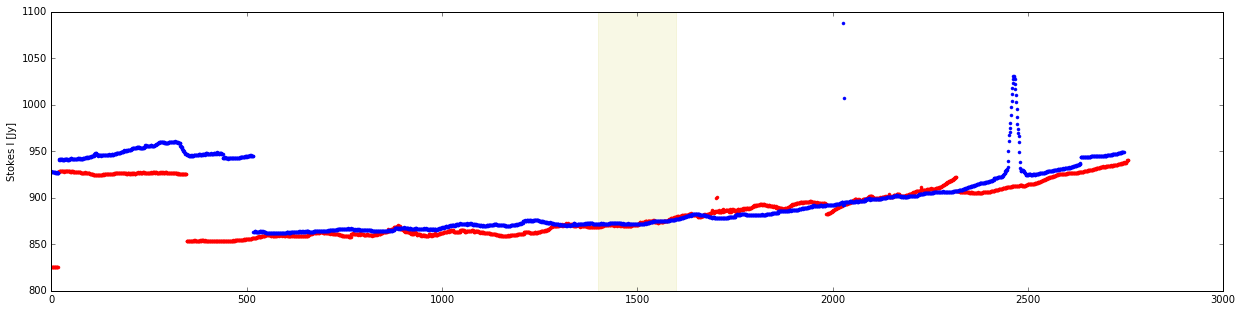

In [4]:
[ts_1560526258,
 stokesI_1560526258] = tabdata('CXOUJ110926_1560526258_beam_split.csv')
# timestamps
ts0 = ts_1560526258[0]
dt_1560526258 = Time(ts_1560526258, format='unix').datetime
ts_1560526258 = (ts_1560526258-ts0)/3600.

[ts_1560609072,
 stokesI_1560609072] = tabdata('CXOUJ110926_1560609072_beam_split.csv')
# timestamps
dt_1560609072 = Time(ts_1560609072, format='unix').datetime
ts_1560609072 = (ts_1560609072-ts0)/3600.

stokesI = np.hstack([stokesI_1560526258, stokesI_1560609072])

fig_, ax_ = plt.subplots(figsize=[21, 5],facecolor='white')
ax_.plot(stokesI_1560526258, 'r.')
ax_.plot(stokesI_1560609072, 'b.')
ax_.axvspan(1400, 1600, alpha=0.1, color='y')
ax_.set_ylabel('Stokes I [Jy]', fontsize=10)

In [5]:
# counts
mean1 = np.mean(stokesI_1560526258[1400:1600])
mean2 = np.mean(stokesI_1560609072[1400:1600])
count_avg = np.average((mean1, mean2))
# flux
flux = 0.002  # Jy
# counts per flux
C = count_avg/flux

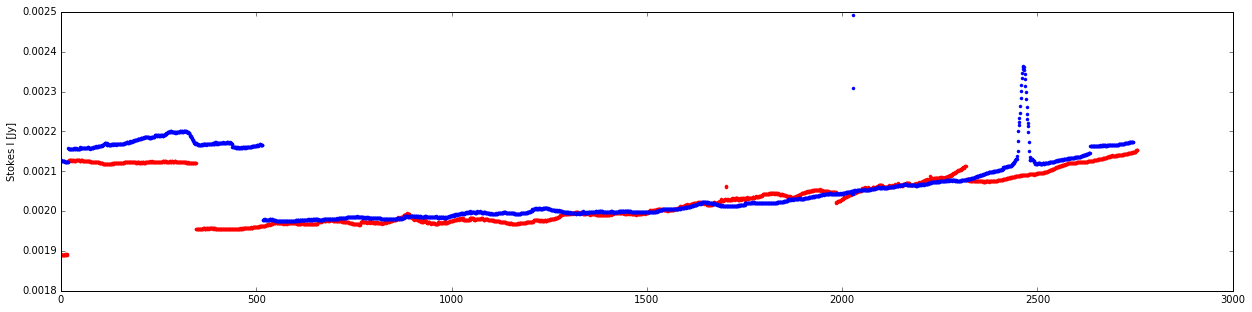

In [6]:
fig_, ax_ = plt.subplots(figsize=[21, 5],facecolor='white')
ax_.plot(stokesI_1560526258/C, 'r.')
ax_.plot(stokesI_1560609072/C, 'b.')
ax_.set_ylabel('Stokes I [Jy]', fontsize=10)

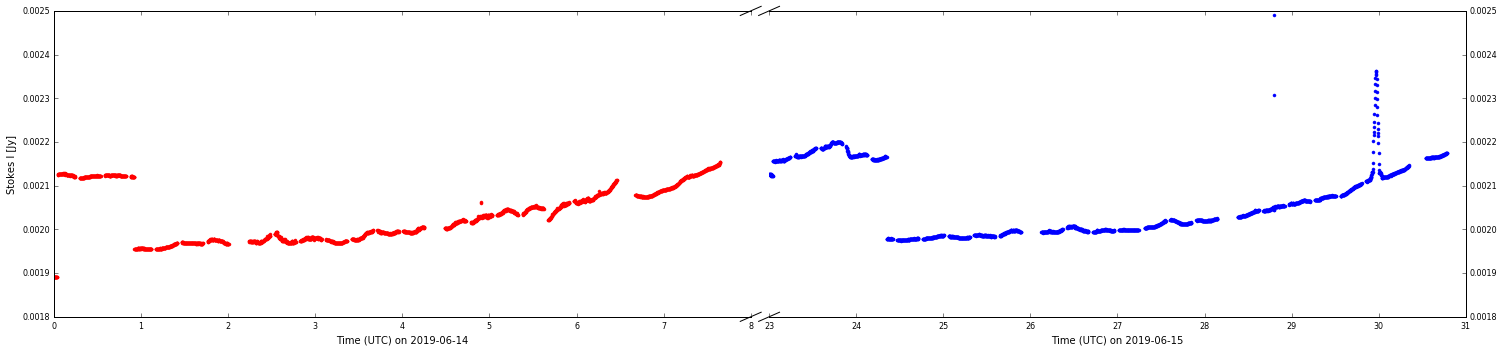

In [7]:
fig_, (ax0,ax1) = plt.subplots(1, 2,
                         sharey=True,
                         figsize=[21, 5],
                         facecolor='white',
                         squeeze=True)
plt.subplots_adjust(wspace=0.1, hspace=0)
ax0.plot(ts_1560526258, stokesI_1560526258/C, 'r.')
ax1.plot(ts_1560609072, stokesI_1560609072/C, 'b.')

d = .015 # how big to make the diagonal lines in axes coordinates
# hide the spines between axes
ax0.spines['right'].set_visible(False)
ax0.yaxis.tick_left()
ax0.tick_params(labelright='off')
ax1.spines['left'].set_visible(False)
ax1.yaxis.tick_right()

# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1-d,1+d), (-d,+d), **kwargs)
ax0.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d,+d), (1-d,1+d), **kwargs)
ax1.plot((-d,+d), (-d,+d), **kwargs)

# axis labels
ax0.tick_params(axis='x', labelsize=8)
ax0.set_xlabel("Time (UTC) on {}".format(
        dt_1560526258[0].strftime("%Y-%m-%d")),
               fontsize=10)
ax0.tick_params(axis='y', labelsize=8)
ax0.set_ylabel('Stokes I [Jy]', fontsize=10)

ax1.tick_params(axis='x', labelsize=8)
ax1.set_xlabel("Time (UTC) on {}".format(
        dt_1560609072[0].strftime("%Y-%m-%d")),
               fontsize=10)
ax1.tick_params(axis='y', labelsize=8)

fig_.tight_layout()